# Analysis of nonlocality of sparse-autoencoder features

## Statistics of feature sparsity

In this section we will analyze the nonlocality of each feature by computing how many tokens activate each feature, and study the statistics. 

/var/folders/xx/809jr4w13lqgcx62t5s5tm380000gn/T/ipykernel_28155/3683967219.py:19: RuntimeWarning: divide by zero encountered in divide
  plt.plot(bin_edges[1:], 1/counts,'r.-')


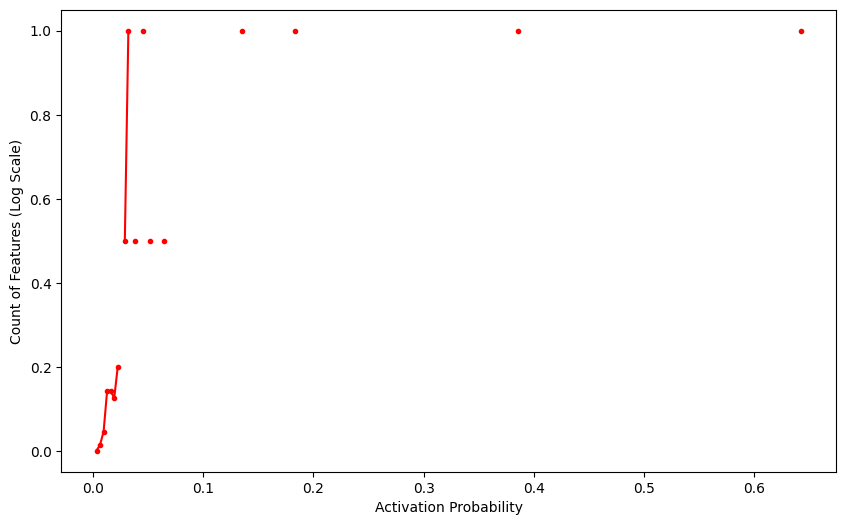

[4735   69   22    7    7    8    5    0    2    1    0    2    0    1
    0    2    0    0    0    2    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    1
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    1    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:

import torch
import matplotlib.pyplot as plt
import numpy as np

# Load the saved data
data = torch.load("feature_sparsity_data.pt")
frequencies = data["frequencies"]
THRESHOLD = data["threshold"]

# Filter out dead features
active_freqs = frequencies[frequencies > 0].cpu().numpy()

counts, bin_edges = np.histogram(active_freqs, bins=200)

plt.figure(figsize=(10, 6))
#plt.hist(active_freqs, bins=200, log=True, color='skyblue', edgecolor='black')
#plt.title(f"Feature Activation Frequency Distribution (Threshold > {THRESHOLD})")

plt.plot(bin_edges[1:], 1/counts,'r.-')
plt.xlabel("Activation Probability")
plt.ylabel("Count of Features (Log Scale)")
#plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

print(counts)

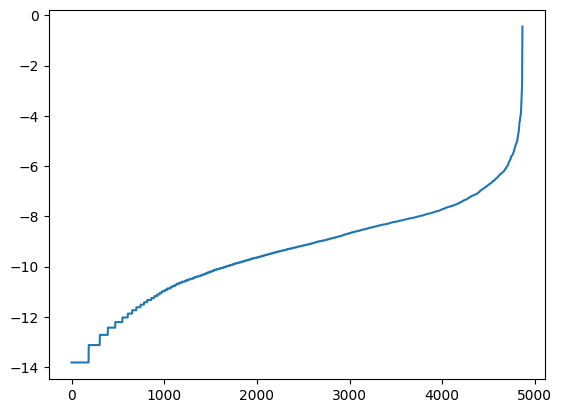

In [12]:
plt.figure()
plt.plot(np.log(np.sort(active_freqs)))
plt.show()

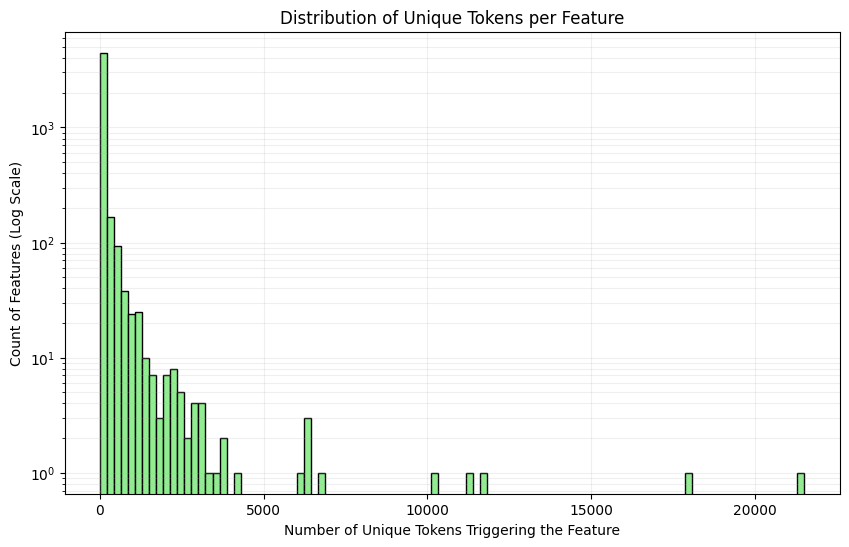

Max unique tokens for a single feature: 21507
Average unique tokens (for active features): 103.56


In [14]:
# Compute number of unique tokens for each feature.

import torch
import matplotlib.pyplot as plt

# 1. Load the data
data = torch.load("feature_sparsity_data.pt")
feature_token_counts = data["feature_token_counts"] # This is a list of Counter objects

# 2. Count unique tokens for each feature
# len(counter) gives the number of unique keys (distinct tokens)
unique_counts = [len(counter) for counter in feature_token_counts]

# 3. Filter out dead features (those with 0 activations)
active_unique_counts = [c for c in unique_counts if c > 0]

counts, bin_edges = np.histogram(active_unique_counts, bins=50)

# 4. Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(active_unique_counts, bins=100, log=True, color='lightgreen', edgecolor='black')
plt.title("Distribution of Unique Tokens per Feature")
plt.xlabel("Number of Unique Tokens Triggering the Feature")
plt.ylabel("Count of Features (Log Scale)")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# Optional: Print some stats
print(f"Max unique tokens for a single feature: {max(unique_counts)}")
print(f"Average unique tokens (for active features): {sum(active_unique_counts)/len(active_unique_counts):.2f}")

/var/folders/xx/809jr4w13lqgcx62t5s5tm380000gn/T/ipykernel_28155/2182102752.py:18: RuntimeWarning: divide by zero encountered in log
  plt.plot(bin_edges[1:], np.log(counts),'ro')


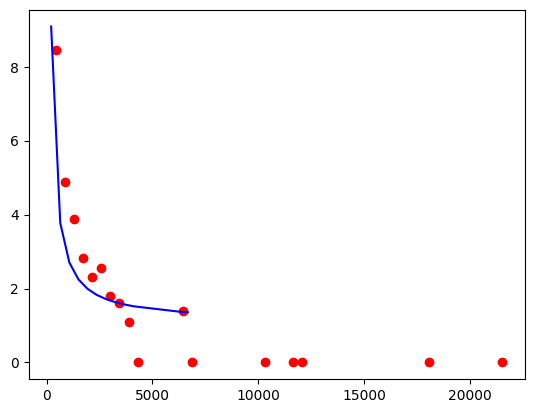

In [26]:
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 2. Filter non-zero bins for log fitting
valid_mask = (counts > 0) & (bin_centers < 10000)
x_data = bin_centers[valid_mask]
y_data = counts[valid_mask]

# 3. Fit Power Law: log(y) = alpha * log(x) + C
# This fits the relationship y = exp(C) * x^alpha
inv_x=1/x_data
log_y = np.log(y_data)

# Fit linear model in log-log space
slope, intercept = np.polyfit(inv_x, log_y, 1)
fitted_y = intercept+inv_x*slope

plt.figure()
plt.plot(bin_edges[1:], np.log(counts),'ro')
plt.plot(x_data, fitted_y,'b-')
plt.show()

The result suggests the following formula:
$$\rho(P) = Ce^{-\mu/P}$$

$\rho(P)$ is the number of features active at a given activation probability $P$.


## Visualize correlation between features

In this section we compute the correlation between features and visualize the results. The correlation is defined by 

$C_{nm}\equiv \left\langle W_nW_m\right\rangle-\left\langle W_n\right\rangle\left\langle W_m\right\rangle$

where the average is taken in
the ensemble of tokens in the provided training text. The correlation matrix is computed by `compute_correlations.py` and saved as `correlation_matrix.pt`.

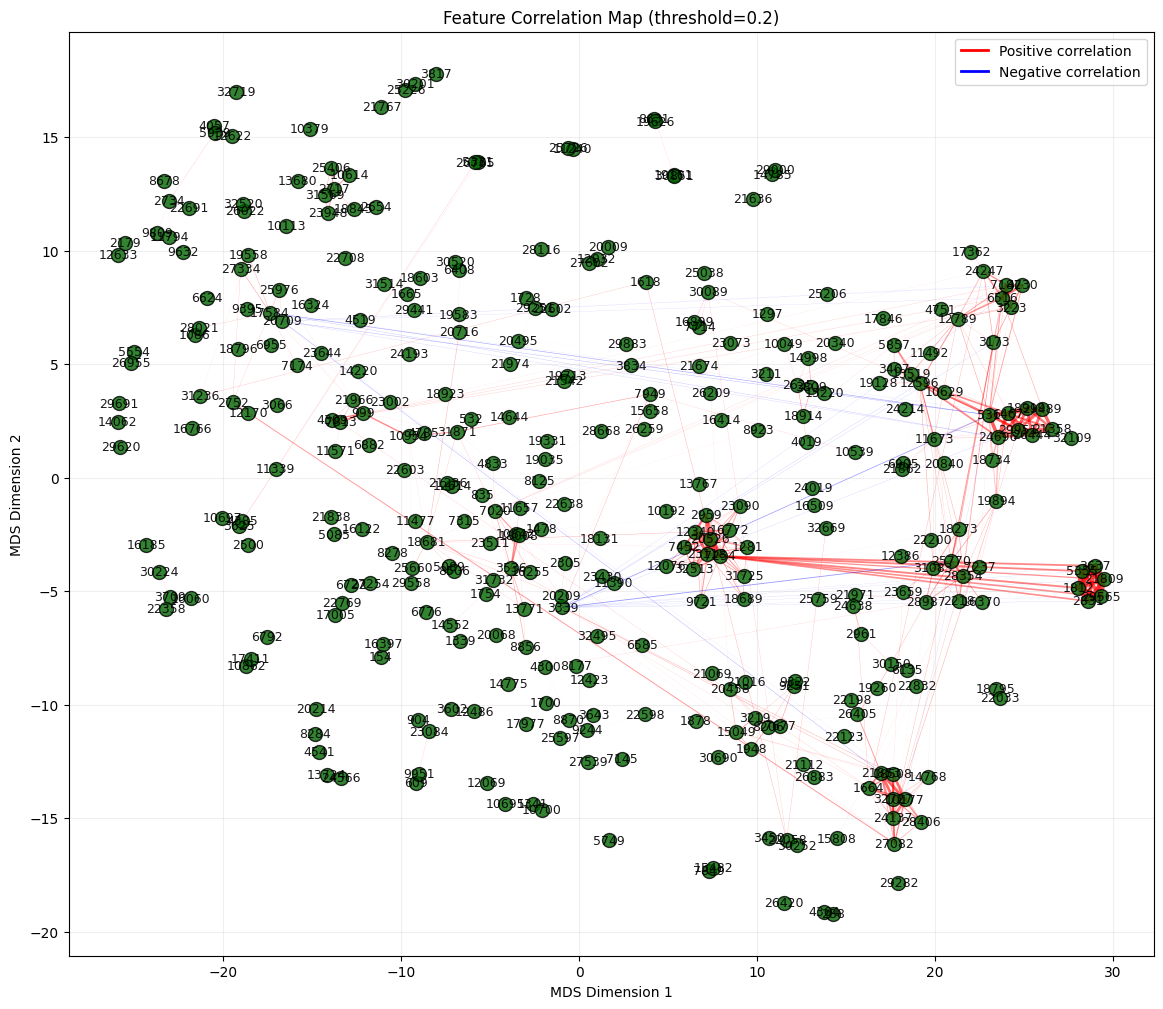

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

# Load correlation matrix
data = torch.load("correlation_matrix.pt")
cov_matrix = data["covariance_matrix"]
leading_features = data["leading_features"]

# Convert covariance to correlation
diag = torch.sqrt(torch.diag(cov_matrix))
denom = torch.outer(diag, diag)
corr_matrix = cov_matrix / (denom + 1e-10)

# Compute distance matrix: D = -log(|Corr|)
abs_corr = torch.abs(corr_matrix)
epsilon = 1e-6
abs_corr = torch.clamp(abs_corr, min=epsilon, max=1.0)
dist_matrix = -torch.log(abs_corr)

dist_from_corr = 1 + 1e-5 - corr_matrix.numpy()
tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=42)
embedding = tsne.fit_transform(dist_from_corr)
# Plot
plt.figure(figsize=(14, 12))

# Draw correlation links
correlation_threshold = 0.2  # Adjust this threshold as needed
max_linewidth = 3.0

# Get correlation matrix as numpy array
corr_np = corr_matrix.numpy()

# Draw lines for correlations above threshold
for i in range(len(leading_features)):
    for j in range(i+1, len(leading_features)):
        corr_value = abs(corr_np[i, j])
        if corr_value > correlation_threshold:
            # Line thickness proportional to correlation strength
            linewidth = (corr_value - correlation_threshold) / (1 - correlation_threshold) * max_linewidth
            # Color: red for positive, blue for negative
            color = 'red' if corr_np[i, j] > 0 else 'blue'
            alpha = 0.3 + 0.4 * (corr_value - correlation_threshold) / (1 - correlation_threshold)
            plt.plot([embedding[i, 0], embedding[j, 0]], 
                    [embedding[i, 1], embedding[j, 1]], 
                    color=color, linewidth=linewidth, alpha=alpha, zorder=1)

# Plot points on top of lines
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.8, c='darkgreen', 
           edgecolors='k', s=100, zorder=2)

# Annotate points
for i, (x, y) in enumerate(embedding):
    plt.annotate(str(leading_features[i]), (x, y), fontsize=9, alpha=0.9, 
                ha='center', va='center', zorder=3)

plt.title(f"Feature Correlation Map (threshold={correlation_threshold})")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.grid(True, alpha=0.2)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='red', lw=2, label='Positive correlation'),
                  Line2D([0], [0], color='blue', lw=2, label='Negative correlation')]
plt.legend(handles=legend_elements, loc='best')

plt.show()

### Plotting the feature importance and feature-feature correlation

In [ ]:
import torch

from sklearn.manifold import MDS
from sklearn.manifold import TSNE

import plotly.graph_objects as go
import numpy as np

# Load feature token counts to get unique token counts
data = torch.load("feature_sparsity_data.pt")
feature_token_counts = data["feature_token_counts"]

# Get unique token counts for leading features
unique_token_counts = []
for feat_idx in leading_features:
    unique_token_counts.append(len(feature_token_counts[feat_idx]))
unique_token_counts = np.array(unique_token_counts)

# Create figure
fig = go.Figure()

# Draw correlation links
correlation_threshold = 0.2
corr_np = corr_matrix.numpy()

# Collect line segments
for i in range(len(leading_features)):
    for j in range(i+1, len(leading_features)):
        corr_value = abs(corr_np[i, j])
        if corr_value > correlation_threshold:
            color = 'red' if corr_np[i, j] > 0 else 'blue'
            width = (corr_value - correlation_threshold) / (1 - correlation_threshold) * 5
            
            fig.add_trace(go.Scatter3d(
                x=[embedding[i, 0], embedding[j, 0]],
                y=[embedding[i, 1], embedding[j, 1]],
                z=[unique_token_counts[i], unique_token_counts[j]],
                mode='lines',
                line=dict(color=color, width=width),
                opacity=0.4,
                showlegend=False,
                hoverinfo='skip'
            ))

# Add scatter points
fig.add_trace(go.Scatter3d(
    x=embedding[:, 0],
    y=embedding[:, 1],
    z=unique_token_counts,
    mode='markers+text',
    marker=dict(
        size=3,
        color=unique_token_counts,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Unique Tokens"),
        line=dict(color='black', width=1)
    ),
    text=[str(f) for f in leading_features],
    textposition='top center',
    textfont=dict(size=9),
    name='Features',
    hovertemplate='Feature: %{text}<br>Unique Tokens: %{z}<extra></extra>'
))

# Update layout
fig.update_layout(
    title=f'Interactive 3D Feature Correlation Map (threshold={correlation_threshold})',
    scene=dict(
        xaxis_title='Embedding Dimension 1',
        yaxis_title='Embedding Dimension 2',
        zaxis_title='Unique Tokens'
    ),
    width=1000,
    height=800
)

fig.show()

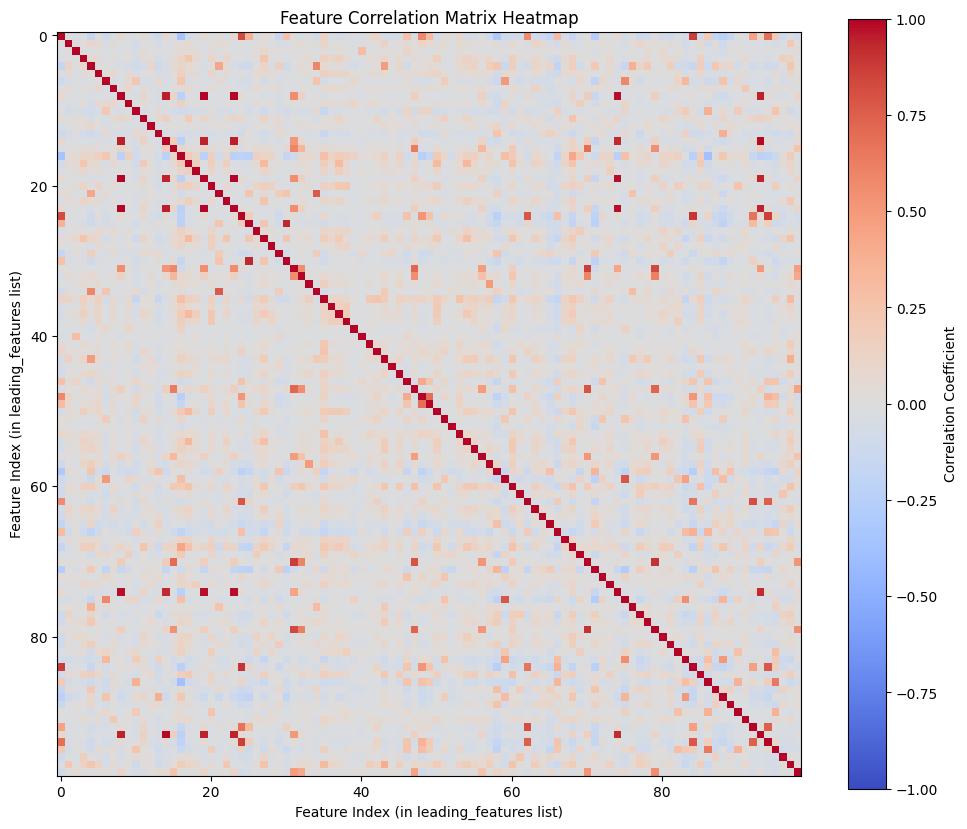

np.float32(1.0000001)

In [23]:
# Heatmap of correlation matrix
plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix.numpy(), cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.title("Feature Correlation Matrix Heatmap")
plt.xlabel("Feature Index (in leading_features list)")
plt.ylabel("Feature Index (in leading_features list)")
plt.show()

np.max(corr_matrix.numpy())

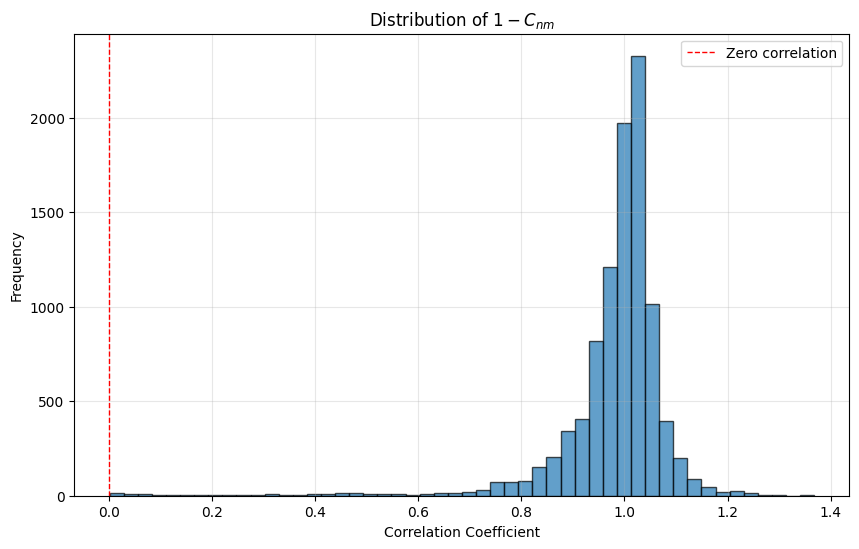

Mean correlation: 0.9809
Median correlation: 1.0032
Std deviation: 0.1149
Min correlation: 0.0010
Max correlation: 1.3681


In [25]:
# plot histogram of the matrix element of corr_matrix
import matplotlib.pyplot as plt
import numpy as np

# Get all correlation values (excluding diagonal)
# Remove diagonal elements (which are 0 after -log(1) = 0)
mask = ~np.eye(corr_matrix.shape[0], dtype=bool)
corr_values = (1+1e-5-corr_matrix.numpy())[mask]


# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(corr_values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of $1-C_{nm}$')
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1, label='Zero correlation')
plt.legend()
plt.show()

# Print statistics
print(f"Mean correlation: {np.mean(corr_values):.4f}")
print(f"Median correlation: {np.median(corr_values):.4f}")
print(f"Std deviation: {np.std(corr_values):.4f}")
print(f"Min correlation: {np.min(corr_values):.4f}")
print(f"Max correlation: {np.max(corr_values):.4f}")